# Kaggle Competition: Bag of Words Meets Bags of Popcorn

This notebook is a slightly modified version from Kaggle's tutorial of the competition https://www.kaggle.com/c/word2vec-nlp-tutorial.

Running this tutorial requires installation of the following packages. In most (or all) cases, we recommend that you use pip to install packages.
```
pandas
numpy
scipy
scikit-learn 
Beautiful Soup
NLTK
Cython
gensim
```

In [1]:
import re
import time
import numpy as np
import pandas as pd
import logging
import nltk.data
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.cross_validation import train_test_split

%matplotlib inline
pd.set_option("display.mpl_style", "default")

In [4]:
# Read data from files 
train = pd.read_csv("data/labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
test = pd.read_csv("data/testData.tsv", header=0, delimiter="\t", quoting=3)
unlabeled_train = pd.read_csv("data/unlabeledTrainData.tsv", header=0, delimiter="\t", quoting=3)

# Verify the number of reviews that were read (100,000 in total)
print "Read %d labeled train reviews, %d labeled test reviews, and %d unlabeled reviews\n" % (train["review"].size, test["review"].size, unlabeled_train["review"].size )

Read 25000 labeled train reviews, 25000 labeled test reviews, and 50000 unlabeled reviews



## Step 1. Train Our Word2Vec Model

In [3]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [29]:
# Examine our raw reviews
raw_review = train.review[0]
print raw_review[:1000], "..."

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

In [30]:
# Remove html tags
sans_html_review = BeautifulSoup(raw_review).get_text()
print sans_html_review[:1000], "..."

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.The actual feature film bit when it finally starts is only on for 20 mi

In [31]:
# Remove non-letters
letters_only_review = re.sub("[^a-zA-Z]"," ", sans_html_review)
print letters_only_review[:1000], "..."

 With all this stuff going down at the moment with MJ i ve started listening to his music  watching the odd documentary here and there  watched The Wiz and watched Moonwalker again  Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  Moonwalker is part biography  part feature film which i remember going to see at the cinema when it was originally released  Some of it has subtle messages about MJ s feeling towards the press and also the obvious message of drugs are bad m kay Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring  Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him The actual feature film bit when it finally starts is only on for    mi

In [5]:
def review_to_wordlist( review, remove_stopwords=False ):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.

    # 1. Remove HTML
    review_text = BeautifulSoup(review).get_text()

    # 2. Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)

    # 3. Convert words to lower case and split them
    words = review_text.lower().split()

    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    # 5. Return a list of words
    return(words)

In [33]:
example_wordlist = review_to_wordlist(train.review[0])
print example_wordlist[:100]

[u'with', u'all', u'this', u'stuff', u'going', u'down', u'at', u'the', u'moment', u'with', u'mj', u'i', u've', u'started', u'listening', u'to', u'his', u'music', u'watching', u'the', u'odd', u'documentary', u'here', u'and', u'there', u'watched', u'the', u'wiz', u'and', u'watched', u'moonwalker', u'again', u'maybe', u'i', u'just', u'want', u'to', u'get', u'a', u'certain', u'insight', u'into', u'this', u'guy', u'who', u'i', u'thought', u'was', u'really', u'cool', u'in', u'the', u'eighties', u'just', u'to', u'maybe', u'make', u'up', u'my', u'mind', u'whether', u'he', u'is', u'guilty', u'or', u'innocent', u'moonwalker', u'is', u'part', u'biography', u'part', u'feature', u'film', u'which', u'i', u'remember', u'going', u'to', u'see', u'at', u'the', u'cinema', u'when', u'it', u'was', u'originally', u'released', u'some', u'of', u'it', u'has', u'subtle', u'messages', u'about', u'mj', u's', u'feeling', u'towards', u'the', u'press']


In [6]:
# Uncomment the next line to download the punkt tokenizer 
# for sentence splitting if it's not already installed.
# nltk.download()

# Load the punkt tokenizer
tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")

In [25]:
sentences = tokenizer.tokenize(train["review"][0])
print sentences[0], "\n"
print sentences[1]

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. 

Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent.


In [7]:
def review_to_sentences( review, tokenizer, remove_stopwords=False ):
    # Function to split a review into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words

    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())

    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list o`f words
            sentences.append( review_to_wordlist( raw_sentence, remove_stopwords ))

    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

In [8]:
%%time
# Get all sentences from the labeled and unlabeled training reviews 
# to build our word2vec corpus. This might take some time.
sentences = []

print "Parsing sentences from training set"
for review in train["review"]:
    try:
        sentences += review_to_sentences(review.decode("utf8"), tokenizer)
    except Exception as e:
        print "Execption raised:", e

print "Parsing sentences from unlabeled set"
for review in unlabeled_train["review"]:
    try:
        sentences += review_to_sentences(review.decode("utf8"), tokenizer)
    except Exception as e:
        print "Execption raised:", e

/Users/exu/devenv/lib/python2.7/site-packages/bs4/__init__.py:182: UserWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  '"%s" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.' % markup)
/Users/exu/devenv/lib/python2.7/site-packages/bs4/__init__.py:189: UserWarning: "http://www.happierabroad.com"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.
  '"%s" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.' % markup)


Parsing sentences from training set
Execption raised: error return without exception set
Parsing sentences from unlabeled set

/Users/exu/devenv/lib/python2.7/site-packages/bs4/__init__.py:189: UserWarning: "http://www.archive.org/details/LovefromaStranger"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.
  '"%s" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.' % markup)
/Users/exu/devenv/lib/python2.7/site-packages/bs4/__init__.py:189: UserWarning: "http://www.loosechangeguide.com/LooseChangeGuide.html"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.
  '"%s" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.' % markup)



Execption raised: error return without exception set
Execption raised: error return without exception set
Execption raised: error return without exception set
Execption raised: error return without exception set
Execption raised:

/Users/exu/devenv/lib/python2.7/site-packages/bs4/__init__.py:189: UserWarning: "http://www.msnbc.msn.com/id/4972055/site/newsweek/"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.
  '"%s" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.' % markup)
/Users/exu/devenv/lib/python2.7/site-packages/bs4/__init__.py:182: UserWarning: ".." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  '"%s" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.' % markup)


 error return without exception set
Execption raised:

/Users/exu/devenv/lib/python2.7/site-packages/bs4/__init__.py:189: UserWarning: "http://www.youtube.com/watch?v=a0KSqelmgN8"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.
  '"%s" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.' % markup)
/Users/exu/devenv/lib/python2.7/site-packages/bs4/__init__.py:189: UserWarning: "http://jake-weird.blogspot.com/2007/08/beneath.html"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.
  '"%s" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.' % markup)


 error return without exception set
CPU times: user 4min 39s, sys: 8.23 s, total: 4min 47s
Wall time: 4min 49s


In [34]:
# Check how many sentences we have in total - should be around 850,000+
print len(sentences)
print sentences[0]

857121
[u'with', u'all', u'this', u'stuff', u'going', u'down', u'at', u'the', u'moment', u'with', u'mj', u'i', u've', u'started', u'listening', u'to', u'his', u'music', u'watching', u'the', u'odd', u'documentary', u'here', u'and', u'there', u'watched', u'the', u'wiz', u'and', u'watched', u'moonwalker', u'again']


In [35]:
%%time
# Set values for various Word2Vec parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model. This might take some time.
print "Training model..."
model = Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

Training model...
CPU times: user 6min 49s, sys: 24.5 s, total: 7min 14s
Wall time: 2min 52s


Use the "top" command from within Terminal (not from within Python) to see if your system is successfully parallelizing while the model is training. Type

```
top -o cpu
```

into a terminal window while the model is training. With 4 workers, the first process in the list should be Python, and it should show 300-400% CPU usage.

In [36]:
# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

#### Checkpoint to Save Our Model

In [ ]:
# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "model/300features_40minwords_10context"
model.save(model_name)

## Exploring the Word2Vec Results

In [13]:
model = Word2Vec.load("model/300features_40minwords_10context")

In [14]:
# The number of rows in syn0 is the number of words in the model's 
# vocabulary, and the number of columns corresponds to the size of 
# the feature vector.
model.syn0.shape

(16486, 300)

In [60]:
# raw numpy vector representation of a word
model["popcorn"][:20]

array([-0.05508476,  0.01472388, -0.04875179, -0.04695245, -0.04852755,
        0.03470666, -0.0558519 ,  0.02382169,  0.06225992, -0.1089793 ,
        0.08998065,  0.03174089, -0.04291321,  0.04327299,  0.05341252,
       -0.08884802, -0.08246919,  0.04227749,  0.00330517, -0.02525405], dtype=float32)

In [17]:
model.most_similar("terrible")[:5]

[(u'horrible', 0.7493797540664673),
 (u'awful', 0.6704462766647339),
 (u'atrocious', 0.6512998342514038),
 (u'horrendous', 0.6150745153427124),
 (u'poor', 0.5838934779167175)]

In [20]:
model.most_similar(positive=["food", "japan"])

[(u'europe', 0.4316524863243103),
 (u'china', 0.4214053153991699),
 (u'korea', 0.41943359375),
 (u'land', 0.4174254238605499),
 (u'poland', 0.41278570890426636),
 (u'population', 0.412203311920166),
 (u'america', 0.4014047682285309),
 (u'civilization', 0.3964836299419403),
 (u'france', 0.39509648084640503),
 (u'eat', 0.3948848247528076)]

In [24]:
model.most_similar(positive=["prince"], negative=["man"])

[(u'cinderella', 0.3126257061958313),
 (u'princess', 0.30653125047683716),
 (u'shearer', 0.2907602787017822),
 (u'aladdin', 0.2891065180301666),
 (u'king', 0.28576189279556274),
 (u'queen', 0.28404444456100464),
 (u'stepmother', 0.2550254762172699),
 (u'rankin', 0.24566881358623505),
 (u'colman', 0.23975101113319397),
 (u'bambi', 0.23945768177509308)]

In [61]:
model.doesnt_match("man woman child puppy".split())

'puppy'

## Step 2. Using Word2Vec Vectors as Features for Our Classifiers

In [9]:
def get_avg_vec(words, model, num_features):
    # Function to average all of the word vectors in a given
    # paragraph (list of words)

    # Pre-initialize an empty numpy array (for speed)
    feature_vec = np.zeros((num_features,),dtype="float32")

    nwords = 0.

    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.index2word)

    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            feature_vec = np.add(feature_vec, model[word])

    # Divide the result by the number of words to get the average
    feature_vec = np.divide(feature_vec, nwords)
    
    return feature_vec


def get_avg_feature_vecs(reviews, model, num_features):
    # Given a set of reviews (each one a list of words), calculate 
    # the average feature vector for each one and return a 2D numpy array 

    # Initialize a counter
    counter = 0.

    # Preallocate a 2D numpy array, for speed
    review_feature_vecs = np.zeros((len(reviews),num_features),dtype="float32")

    # Loop through the reviews
    for review in reviews:
       # Print a status message every 1000th review
       if counter%5000. == 0.:
           print("Review %d of %d" % (counter, len(reviews)))

       # Call the function (defined above) that makes average feature vectors
       review_feature_vecs[counter] = get_avg_vec(review, model, num_features)

       # Increment the counter
       counter = counter + 1.
        
    return review_feature_vecs

In [89]:
# get vector averages example
print model["coffee"][:5]
print model["pancake"][:5]
print get_avg_vec(["coffee", "pancake"], model, 300)[:5]

[-0.00721838  0.05198835 -0.00485179 -0.02605511 -0.01010045]
[ 0.02911175 -0.01660328 -0.11955155  0.08475109  0.07054239]
[ 0.01094669  0.01769254 -0.06220167  0.02934799  0.03022097]


In [10]:
feature_vecs = get_avg_feature_vecs([["a", "good", "review"],["another", "review"]], model, 300)
print feature_vecs.shape
feature_vecs[0][:5]

Review 0 of 2
(2, 300)


array([ 0.00173065,  0.02284304,  0.01426945, -0.00094139,  0.01773121], dtype=float32)

In [11]:
%%time
train_review_wordlists = []

for review in train["review"]:
    try:
        # Convert each training review into a list of words
        train_review_wordlists.append(review_to_wordlist(review))
    except Exception as e:
        train_review_wordlists.append(review_to_wordlist("I'm a placeholder sentence."))
        print "Execption raised:", e

Execption raised: error return without exception set
Execption raised: error return without exception set
Execption raised: error return without exception set
CPU times: user 1min 20s, sys: 1.18 s, total: 1min 21s
Wall time: 1min 22s


In [12]:
num_features = 300
# Calculate average feature vectors for training and testing sets

train_review_vecs = get_avg_feature_vecs( train_review_wordlists, model, num_features )

Review 0 of 25000
Review 5000 of 25000
Review 10000 of 25000
Review 15000 of 25000
Review 20000 of 25000


In [96]:
print "Total of", len(train_review_vecs), "reviews. Each with", len(train_review_vecs[0]), "averaged word vectors as features."

Total of 25000 reviews. Each with 300 averaged word vectors as features.


In [97]:
# Split our labeled reviews into training (70%) and testing sets (30%)

X = train_review_vecs
y = train["sentiment"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

### Random Forest Classifier

In [98]:
print "Fitting a random forest to labeled training data..."
forest = RandomForestClassifier(n_estimators = 100)
forest.fit(X_train, y_train)

print 'Test Accuracy: %.2f'% forest.score(X_test, y_test)

Fitting a random forest to labeled training data...
Test Accuracy: 0.83


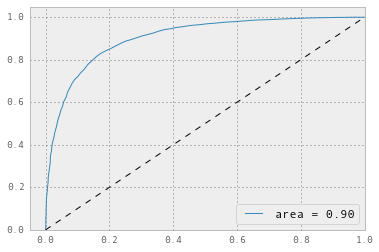

In [103]:
# Plot the ROC curve
pred_probas = forest.predict_proba(X_test)[:,1]

false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test, pred_probas)
roc_auc = auc(false_pos_rate, true_pos_rate)
plt.plot(false_pos_rate, true_pos_rate, label='area = %.2f' %roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')

plt.show()

### Stochastic Logistic Regression

In [100]:
lr = SGDClassifier(loss='log', penalty='l1')
lr.fit(X_train, y_train)

print 'Test Accuracy: %.2f'% lr.score(X_test, y_test)

Test Accuracy: 0.84


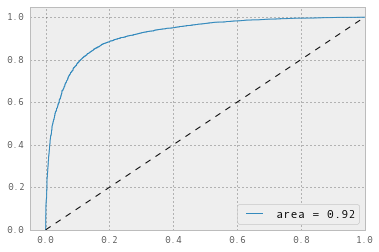

In [102]:
pred_probas = lr.predict_proba(X_test)[:,1]

false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test, pred_probas)
roc_auc = auc(false_pos_rate, true_pos_rate)
plt.plot(false_pos_rate, true_pos_rate, label='area = %.2f' %roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')

plt.show()

## Next Step: Replacing Word2Vec with Doc2Vec

Word2Vec is different from bag-of-words because of its ability to capture the context of surrounding words. However, the ordering of words is not reflected in its vector values. Using the averages of word2vec vectors works fine on shorter lengths of texts like tweets. Once we go to the paragraph scale, however, we risk throwing away rich features when we ignore word order and context. In this case it is better to use Doc2Vec to create our input features.

Next time we will see if using doc2vec can further improve our model's accuracy.